# under construction

**Goal:** In this notebook you will learn how to define models are able to model the output as a conditional probability distribution of a Normal distribution for regression problems. You will define difrerent models with Keras and Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution of a Normal distribution with a constant, montonic and non-linear felxible standart deviation, the mean of the CPD will always be linear. You compare the 3 modesl with the NLL on a validaiton set and use the one with the lowest NLL to predict the test set. Finally, you will also make out of sample predicitons with the best model and look how the predicted CPD behaves.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. In addition you will find three exercises where you can do some experiments by yourself.

**Dataset:** 
You work with a simulated dataset that looks a bit like a fish. The data has a linear slope but non-constant variance, the variance starts with a large value then slowly decreases to increase again and in the end it decreases again. You split the data into train, validation and test dataset.

**Content:**
* Simulate the splitting of the dataset 
* Fit a model with keras and TFP that models the CPD with a linear mean and a fixed standart deviation
* Fit a model with keras and TFP that models the CPD with a linear mean and monotoic standart deviation
* Fit a model with keras and TFP that models the CPD with a linear mean and non linear standart deviation (by adding hidden layers)
* Compare the different model with the NLL loss on the validation dataset
* Choose one of these model to predict the test dataset and calculate the NLL on the test data
* Make a prediction for out of sample x values with the best model


| [open in colab](TODO_link)



In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0
TF  Version 2.0.0-alpha0


### Working with a TFP Normal distribution

In [4]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=[3], scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution 

tf.Tensor(
[[3.4912028]
 [1.7360613]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.2520768 ]
 [0.18648346]], shape=(2, 1), dtype=float32)


### Simulate the fishlike data

In the next few cells you will simulate some data that looks like a fish.You will fist simulate random distributed noise with non constant varaiance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y= 2.7*x+noise (linear slope of 2.7 and intercept of 0) . The variance of the noise will change, it starts with high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance. Let's sample random distributed noise with that variance. 

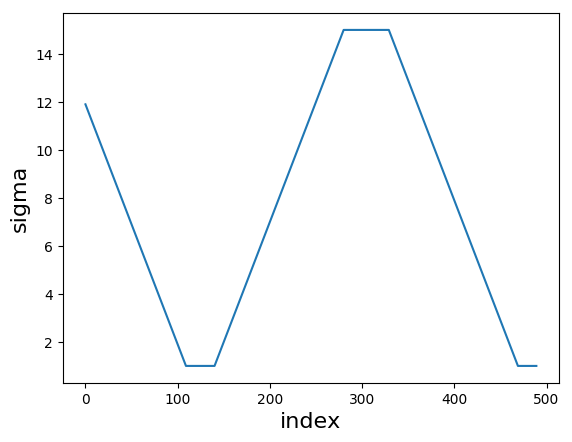

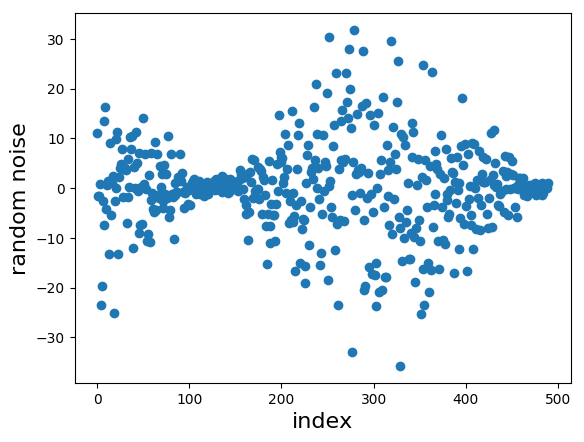

In [5]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()

np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
#plot the noise that you add to a linear regression
plt.scatter(np.arange(0,len(noise),1),noise)
plt.xlabel("index",size=16)
plt.ylabel("random noise",size=16)#pred
plt.show()


Now you will sample random uniformly distributed x values in the range from -1 to 6. you will sample less x values in the range from -1 to 1 which will be the first part of the random distributed variance where the noise is decrasing. The dataset will have more x values in the range from 1 to 6 than in the range from -1 to 1. You will generate as much x values as we have random noise points. Finally you want to sort the x values (for ploting reasons). 

In [0]:
# generation the x values for the simulated data
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data comple. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [0]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [0]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [0]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train diffrent models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model (lowest NLL on the validation dataset). It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction for it. That is the reason why you will plot it only in the end.


(-30, 55)

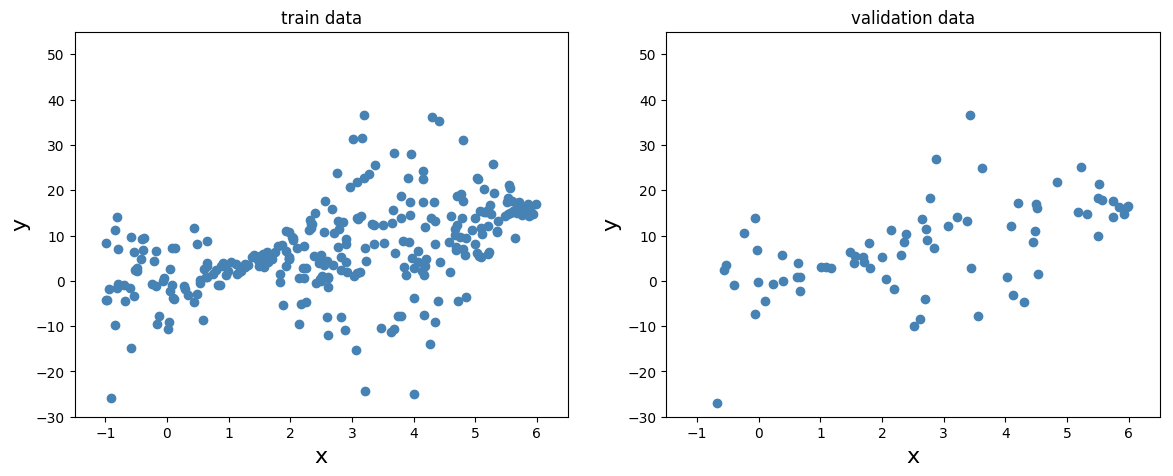

In [11]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

## Fit linear regression with constant variance (sigma = 1)

In the next cells you will define and fit a linear model on the simulated fish data with keras and the tensorflow probability framework. You define a simple linear regression NN with only two parameters to model the output as a conditional probability distribution of a Normal distribution with a constant sigma = 1 (scale). As the loss function you use the NLL which is a lot easier to define in the tensorflow probability framework (see A).


In [146]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
def NLL(y, distr): 
  return -distr.log_prob(y) #A

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=1)# set the sd to the fixed value 1

inputs = Input(shape=(1,))
params = Dense(1)(inputs)#C

dist = tfp.layers.DistributionLambda(my_dist)(params) #D
model_sd_1 = Model(inputs=inputs, outputs=dist)
model_sd_1.compile(Adam(learning_rate=0.01), loss=NLL) #E

#A Function to compute the NLL of an observed y under the fitted distribution distr. 
#B Function to utilize the output of the last layer (params) as the parameter(s) of a distribution
#C Setting up the NN with one output node
#D Calling a distributional layer to take the function my_dist with arguments params.  
#E Compiling the model with NLL as loss function

model_sd_1.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2         
_________________________________________________________________
distribution_lambda_8 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_sd_1.fit(x_train, y_train, epochs=1000, verbose=0, validation_data=(x_val,y_val))

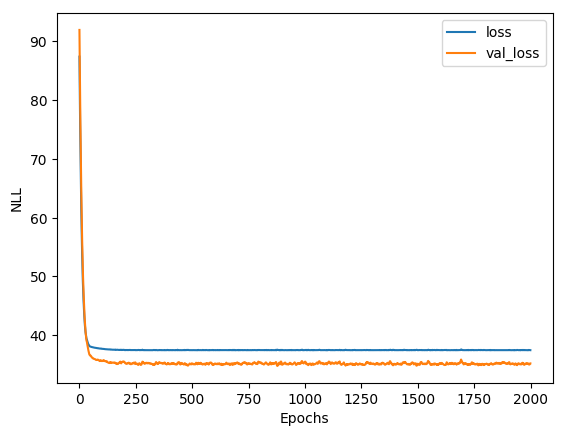

In [148]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In the next cell you define a model that predicts only the mean of the output distribution.

In [0]:
model_mean_sd_1 = Model(inputs=inputs, outputs=dist.mean())

You see a nice decrease of the training and validation loss and after some time the loss converges. Let's evaluate the final train and validation loss.

In [150]:
print(model_sd_1.evaluate(x_train,y_train))
print(model_sd_1.evaluate(x_val,y_val))

293/293 [==============================] - 0s 42us/sample - loss: 37.4581
37.4580879728135
74/74 [==============================] - 0s 56us/sample - loss: 35.2113
35.2112844570263


Now you will plot the trained model with the resulting mean and +-2  sigma at each x value and see how well it fits the conditional probability distribution of y given x. Remember in this first model you used a linear model for the mean of the distribution and just fixed the standart deviation sigma to a constant and equal to 1 (note that you simulated the variace to be non-constant!).

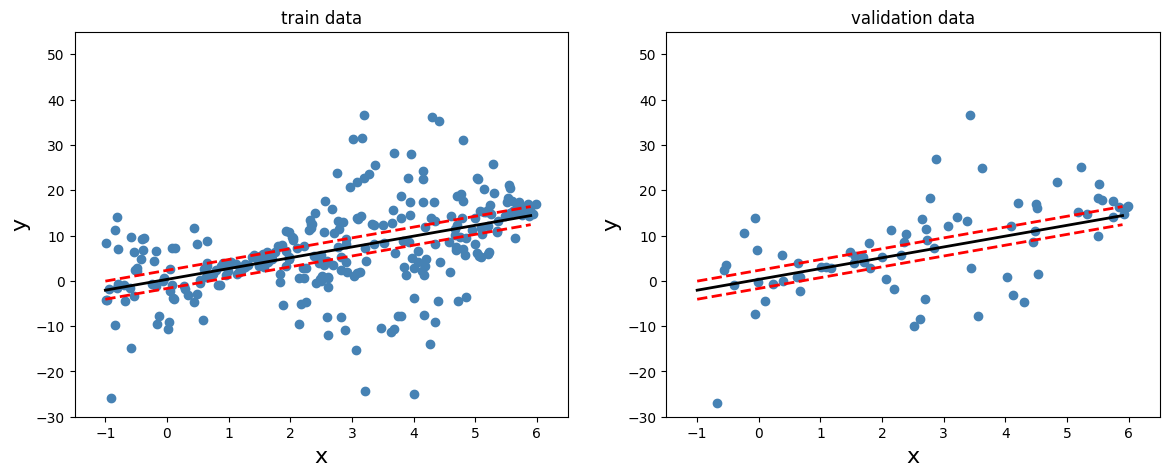

In [151]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_1.predict(x_pred)
sigma = 1
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

### Does the NLL depend on sigma, What happens with mu?

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the constant variance sigma in the network form 1 to 5, retrain the network and calculate the NLL for the training and validation data with model.evaluate() function. What do you observe, is the NLL independent of sigma? What do you observe for the mu values with constant simga 1 and 5?
What would be the optimal constant sigma that leads to the lowest NLL?*

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

You can use the same network as before just change the scale parameter in the Normal distribution .

In [153]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params, scale=5)# set the sd to the fixed value 5

inputs = Input(shape=(1,))
params = Dense(1)(inputs)

dist = tfp.layers.DistributionLambda(my_dist)(params) 
model_sd_5 = Model(inputs=inputs, outputs=dist)
model_sd_5.compile(Adam(learning_rate=0.01), loss=NLL) 

model_sd_5.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 2         
_________________________________________________________________
distribution_lambda_9 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_sd_5.fit(x_train, y_train, epochs=1000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_mean_sd_5 = Model(inputs=inputs, outputs=dist.mean())

Text(0.5, 0, 'Epochs')

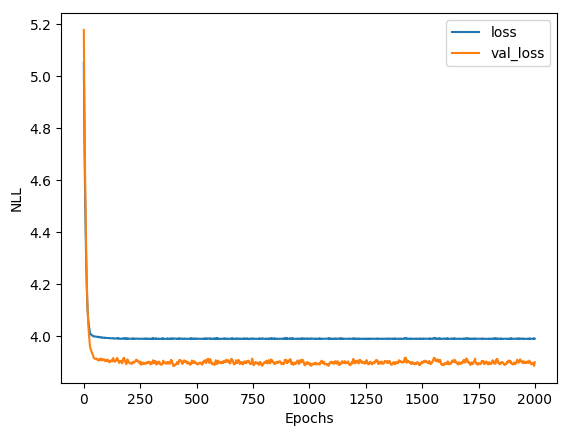

In [156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

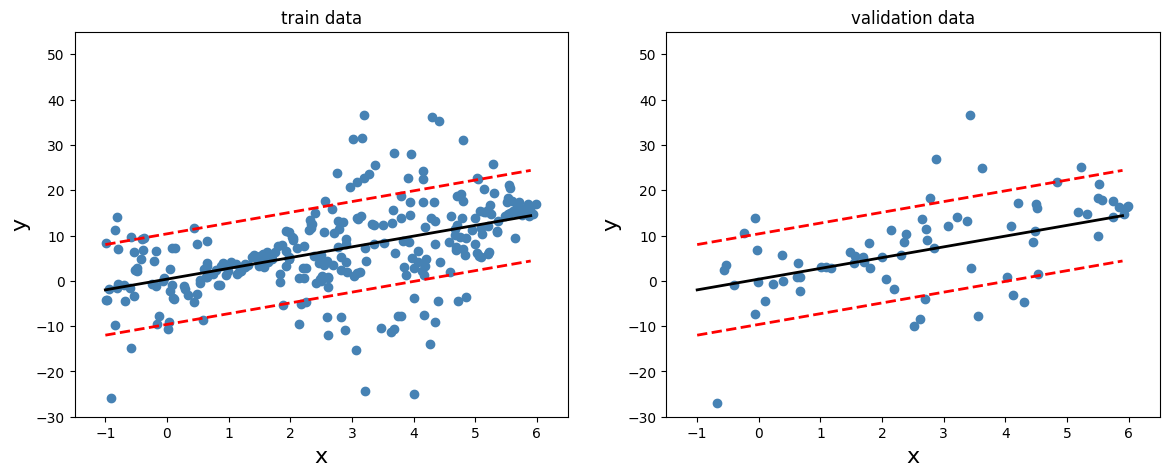

In [160]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)


plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = 5
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


In [161]:
print(model_sd_5.evaluate(x_train,y_train))
print(model_sd_5.evaluate(x_val,y_val))

293/293 [==============================] - 0s 60us/sample - loss: 3.9900
3.989978534776603
74/74 [==============================] - 0s 113us/sample - loss: 3.9002
3.900227920429127


**If you compare the NLL for validation data, you see that the NLL for the model with sigma=5 is much lower NLL ~3.9 than the model with sigma=1 ~35. So the NLL is highly dependent on sigma! If you look at the predictions plots with +- 2 sigma you can see that there are a lot more points inside taht band when you have constant sigma = 5 then when you have constnat sigma = 1, this means that all this this points inside the +-2 sigma band are much more likey to be oberveed, that's why the NLL for the fixed sigma=5 is much lower.**

In [162]:
# comapre the predicedt mean for the first 5 values with fixed simga=1 and sigma=5
(model_mean_sd_1.predict(x_val)-model_mean_sd_5.predict(x_val))[0:5]

array([[-0.06471026],
       [-0.06314135],
       [-0.06285459],
       [-0.0612033 ],
       [-0.05916932]], dtype=float32)

**Let's compare the the predicted means for all validation poits. As you can see the differences for the mean values of the model with constant sigma=1 and sigma=5 are very small and close to 0. So the predicted mean value of the conditional probability distribution does not depend on sigma.**

You saw that the NLL depends on the standart deviation sigma and that the loss is lower if you assume a fixed sigma of 5 comapred to a fixed sigma 1, but what would be optimal sigma that minimizes the NLL? To solve this and calculate the constant sigma that minimizes the NLL you can use the formula from section XXX.

In [163]:
preds_train = model_mean_sd_5.predict(x_train)
preds_val = model_mean_sd_5.predict(x_val)

SSR= np.sum(np.square(y_train-preds_train))
sigma_=np.sqrt((SSR)/(len(x_train)-2))
sigma_

8.578016026088841

**To calculate the NLL with the optimal constant sigma, you can use the formula for the $$NLL = \frac{1}{n}\sum_{i=1}^{n}- log(\frac{1}{\sqrt{2 \pi \sigma^2_x}})+\frac{(y_i - \mu_i)^2}{2 \sigma^2_x}$$ or use the probability density function of the Normal distribution form the scipy.stats library.
You see that indeed the NLL with ~ 3.5 calculated with the estimated constant sigma ~ 8.5 is smaller than the constant sigma of 5 (~3.9).**

In [164]:
#loss with the estimated sigma
NLL_train=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                  ((np.square(y_train-model_mean_sd_5.predict(x_train))/(2*np.square(sigma_)))))
print(NLL_train)
NLL_val=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model_mean_sd_5.predict(x_val))/(2*np.square(sigma_)))))
print(NLL_val)

3.5647282182923576
3.534234991061094


In [165]:
import scipy.stats
print(np.mean(-np.log(scipy.stats.norm(model_mean_sd_5.predict(x_train), sigma_).pdf(y_train))))
print(np.mean(-np.log(scipy.stats.norm(model_mean_sd_5.predict(x_val), sigma_).pdf(y_val))))

3.5647282182923576
3.534234991061094


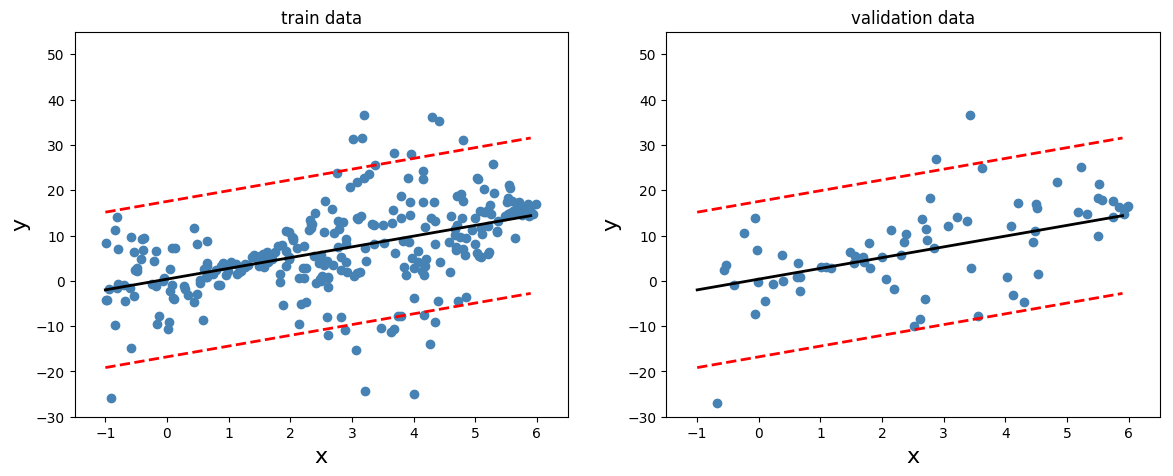

In [166]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = sigma_
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


## Fit linear regression allow the sd to depend in a monotonic way on the input

You probability already know that it's is not the best idea to model the standart deviation sigma with a constant value since itincreases and decreases over time, think of how the data was simulated. So let's try to model the standart deviation sigma in a minotonic way and compare the NLL on the validation set with our best model so far, which was the one with the optimal estimated constant sigma that had a NLL of ~3.5.  To define a monotonic standart deviation, you can use again a Normal distribution in TFP, but this time you dont fix a sigma but you fit both parameters the mean and sigma and you don't use any hidden layers in between (go to the book to read about the softplus  transformation for sigma). As the loss function you use again the NLL.

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
params = Dense(2)(inputs)
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_monotoic_sd = Model(inputs=inputs, outputs=dist)
model_monotoic_sd.compile(Adam(learning_rate=0.01), loss=NLL) 

In [172]:
model_monotoic_sd.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_12 (Dist ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_monotoic_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In the next cell you define two models to predict the mean $\mu$ and the standart deviation $\sigma$ of the output distribution.

In [0]:
model_monotoic_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_monotoic_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

Text(0.5, 0, 'Epochs')

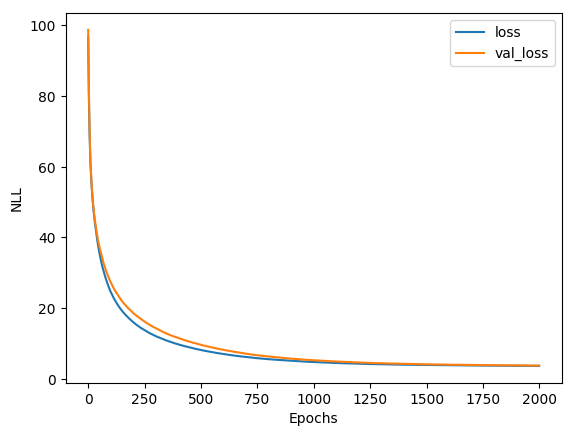

In [175]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [176]:
print(model_monotoic_sd.evaluate(x_train,y_train))
print(model_monotoic_sd.evaluate(x_val,y_val))

293/293 [==============================] - 0s 76us/sample - loss: 3.6562
3.656226023065352
74/74 [==============================] - 0s 71us/sample - loss: 3.7570
3.7569746004568563


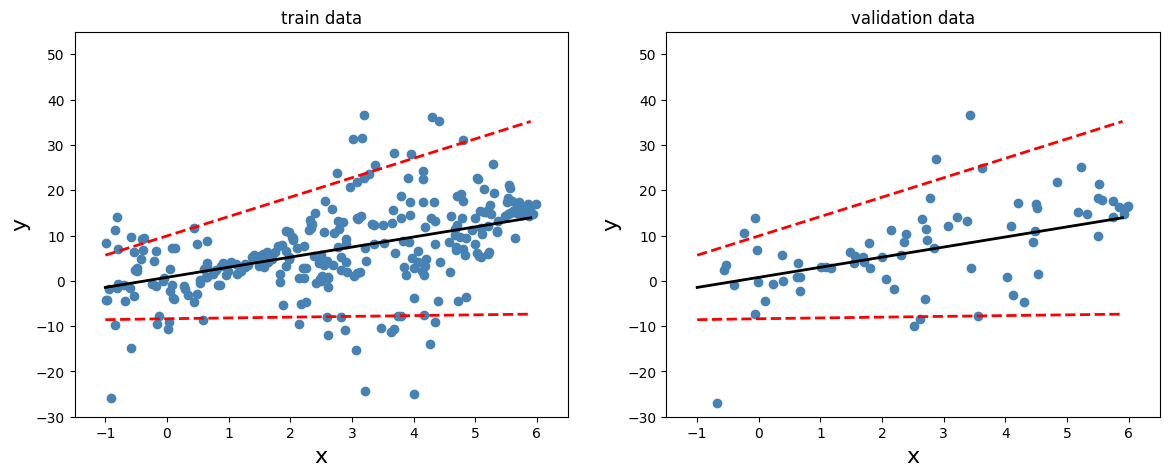

In [177]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_monotoic_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

Now that you have trained and ploted the model with the resulting mean and +-2  sigma at each x value you see how well it fits the conditional probability distribution of y given x.You see that the standart deviation is no longer constant but also increases with bigger x-values. The mean of the distribution is still linear because there are no hidden layers in this model. Even if this model is more complex than the ones before the NLL on the validation set with ~3.7 is unfortunately still higher compared to the model with the estimated constant sigma, which had a NLL of ~3.5. The main reason for this is because the simulated variance gets very small between the x values 5 and 6.

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

From the model with the monotonic standart deviation you probability guessed that you need a model where the standart deviation sigma is non-linear and able to increas for some x-values but then agian decrease for others. Remeber how the data was simulated. Let's try that and see if we can decrease the NLL below ~3.5. You will now, define and fit a model that models the mean of the normal distribution linearly (no hidden layer for the mean parameter) but for the standart devation sigma, you will use 2 hidden layers in beetween (with 20 and 10 nodes) so the stadart deviation is able to be non-linar if necessary. You will use again TFP and keras for the model defintion. The loss function you use again the NLL.

In [0]:
def NLL(y, rv_y):
  return -rv_y.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
out1 = tf.keras.layers.Dense(1)(inputs)
hidden1 = tf.keras.layers.Dense(20,activation="relu")(inputs)
hidden2 = tf.keras.layers.Dense(10,activation="relu")(hidden1)
out2 = tf.keras.layers.Dense(1)(hidden2)
params = tf.keras.layers.Concatenate()([out1,out2])
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(), loss=NLL)


In [181]:
model_flex_sd.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 20)           40          input_16[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 10)           210         dense_25[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 1)            2           input_16[0][0]                   
___________________________________________________________________________________________

In [0]:
history = model_flex_sd.fit(x_train, y_train, epochs=4000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_flex_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

Text(0.5, 0, 'Epochs')

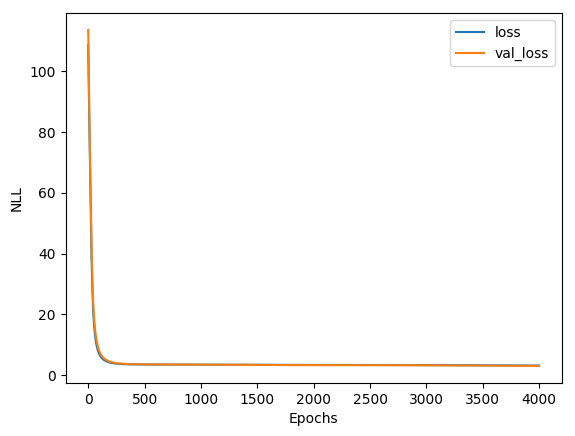

In [184]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [187]:
print(model_flex_sd.evaluate(x_train,y_train))
print(model_flex_sd.evaluate(x_val,y_val))

293/293 [==============================] - 0s 72us/sample - loss: 3.2199
3.2198967111802346
74/74 [==============================] - 0s 149us/sample - loss: 3.1076
3.1076465426264583


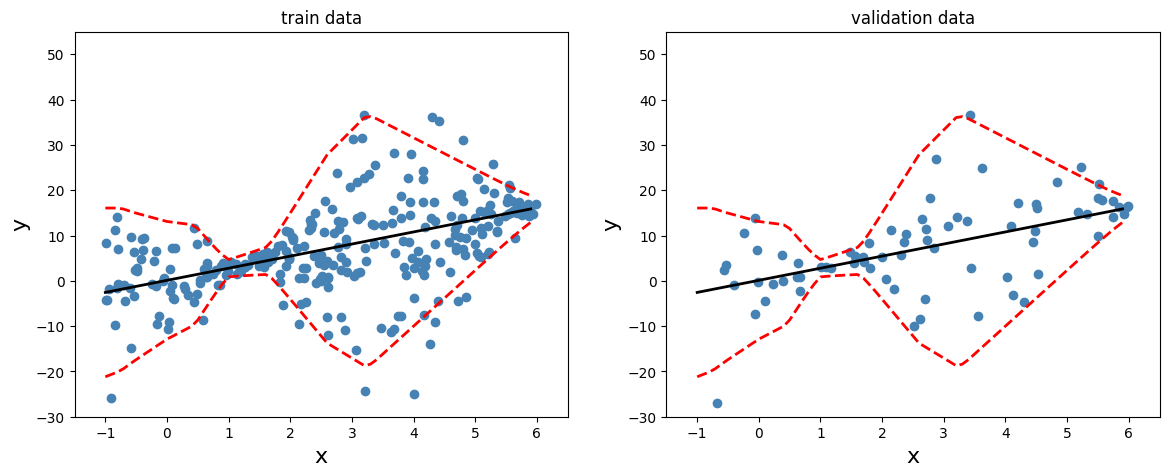

In [188]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


Now that you have trained and ploted the model with the resulting mean and +-2  sigma at each x value you see how well it fits the conditional probability distribution of y given x. It looks really nice, just like a fish and exacly how we simulated the data. You see that the standart deviation is not constant but non-linear, it increases and decreases when necessary. The mean of the distribution is still linear because there are still no hidden layers for the mean in this model. If you look at the NLL on validation dataset you see that it really is lower than ~3.5, it now is only ~3.1. So with this more complex model we get the lowest NLL on the  the validation set!

### Prediction of the test with the best model

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 2: Which of the models above that you have used is the best for new unseed data? Use this model to predict the test set and calculate the NLL for the test set. Is the NLL in the range that you expected?*

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

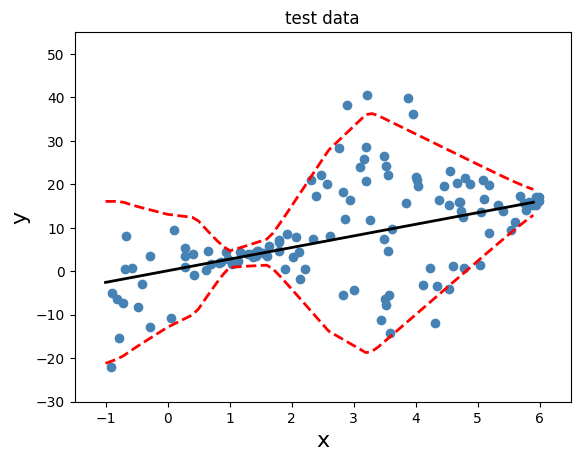

In [189]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_pred = np.arange(-1,6,0.1)
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

In [190]:
model_flex_sd.evaluate(x_test,y_test)

123/123 [==============================] - 0s 68us/sample - loss: 3.1928


3.1927953192858194

In [191]:
np.mean(-model_flex_sd(x_test).log_prob(y_test))

3.1927953

In [192]:
NLL_test=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(model_flex_sd_sd.predict(x_test)))))+
                 ((np.square(y_test-model_flex_sd_mean.predict(x_test))/(2*np.square(model_flex_sd_sd.predict(x_test))))))
print(NLL_test)

3.1927952722186936


**The best model for new unseen data is the one with the lowest NLL on the validation dataset. So you use the model with the linear mean and the non-linear stadart deviation to predict the test dataset. The expected NLL should be around 3.1, which is the NLL that you observed for the validation dataset, and it turns out that the NLL for the  testdataset is around that.**

### Prediction outside the x range

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Optinal Exercise 3:Predict the mean and sigma for a x-range from -5 to 10. What do you observe?*

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

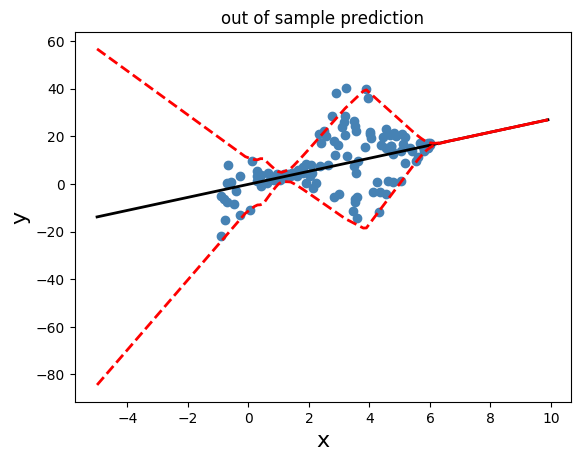

In [55]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_new=np.arange(-5,10,0.1)
preds_new = model_flex_sd_mean.predict(x_new)
plt.plot(x_new,preds_new,color="black",linewidth=2)
plt.plot(x_new,preds_new+2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2) 
plt.plot(x_new,preds_new-2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("out of sample prediction on test data")
plt.show()

**You can see that the out of sample prediction ...**

In [0]:
from google.colab import files
data=np.column_stack([x_train,y_train,model_mean_sd_5.predict(x_train),np.repeat(sigma_,len(x_train)),
                 model_monotoic_sd_mean.predict(x_train),model_monotoic_sd_sd.predict(x_train),
                 model_flex_sd_mean.predict(x_train),model_flex_sd_sd.predict(x_train)])
import pandas as pd
train=pd.DataFrame(data,columns=["x_train","y_train","mu_const","sigma_const","mu_monotonic","sigma_monotonic","mu_flex","sigma_flex"])
train.to_csv("ch05_01_train.csv",sep=",",index=False,header=True)
files.download('ch05_01_train.csv') 

In [0]:
from google.colab import files
data=np.column_stack([x_val,y_val,model_mean_sd_5.predict(x_val),np.repeat(sigma_,len(x_val)),
                 model_monotoic_sd_mean.predict(x_val),model_monotoic_sd_sd.predict(x_val),
                 model_flex_sd_mean.predict(x_val),model_flex_sd_sd.predict(x_val)])
import pandas as pd
train=pd.DataFrame(data,columns=["x_val","y_val","mu_const","sigma_const","mu_monotonic","sigma_monotonic","mu_flex","sigma_flex"])
train.to_csv("ch05_01_val.csv",sep=",",index=False,header=True)
files.download('ch05_01_val.csv') 

In [0]:
from google.colab import files
data=np.column_stack([x_test,y_test,model_mean_sd_5.predict(x_test),np.repeat(sigma_,len(x_test)),
                 model_monotoic_sd_mean.predict(x_test),model_monotoic_sd_sd.predict(x_test),
                 model_flex_sd_mean.predict(x_test),model_flex_sd_sd.predict(x_test)])
import pandas as pd
train=pd.DataFrame(data,columns=["x_test","y_test","mu_const","sigma_const","mu_monotonic","sigma_monotonic","mu_flex","sigma_flex"])
train.to_csv("ch05_01_test.csv",sep=",",index=False,header=True)
files.download('ch05_01_test.csv') 

In [0]:
### aufgabe für sinus, spliting selber, netz vorgen, hidden dazu oder nicht? 
### fragen wie man das am besten modelieren soll